# Import Dependencies

In [1]:
import numpy as np
from scipy.stats import multivariate_normal as normal
import torch
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

# Gaussian Mixture Model Definition

In [19]:
class GaussianMixtureModel:

    def __init__(self, X, **kwargs):
        self.X = X
        self.N,self.D = X.shape
        self.set_options(**kwargs)

    def set_options(self, **kwargs):
        self.epochs = kwargs['epochs'] if 'epochs' in kwargs else 100
        self.threshold = kwargs['threshold'] if 'threshold' in kwargs else 1e-2
        self.early_break = kwargs['early_break'] if 'early_break' in kwargs else True

    def difference_vectors(self):
        # K x N x D
        self.DIFF = self.X - self.mu.reshape([ self.K , 1 , self.D ])

    def gaussian(self, K):
        # K x N
        self.Gauss = np.array([ normal.pdf(self.X, mean=self.mu[k,:], cov=self.Sigma[k,:,:]) for k in range(K) ])

    def responsibility(self):
        # K x N
        self.r = (self.pi * self.Gauss) / (self.pi * self.Gauss).sum(axis=0, keepdims=True)
    
    def mean(self):
        # K x D
        self.mu = (self.r @ self.X) / self.r.sum(axis=1, keepdims=True)
    
    def covariance(self, K):
        # K x D x D
        DIFF = self.X - self.mu.reshape([ K , 1 , self.D ])
        self.Sigma = (self.r[:,:,None] * DIFF).transpose(0,2,1) @ DIFF
        self.Sigma /= self.r[:,:,None,None].sum(axis=1)
        self.Sigma += 1e-8 * np.eye(self.D)
    
    def pi_k(self):
        # K x 1
        self.pi = self.r.sum(axis=1, keepdims=True) / self.N

    def fit(self, K):

        # assign starting mean, covariance, & pi at random
        self.mu = np.random.randn(K,self.D)
        self.Sigma = np.abs(np.array([ np.random.randn(self.D,1) * np.eye(self.D) for k in range(K)]))
        self.pi = np.random.randn(K,1)

        J = []

        for epoch in range(self.epochs):

            self.gaussian(K)
            self.responsibility()
            self.mean()
            self.covariance(K)
            self.pi_k()

# Example

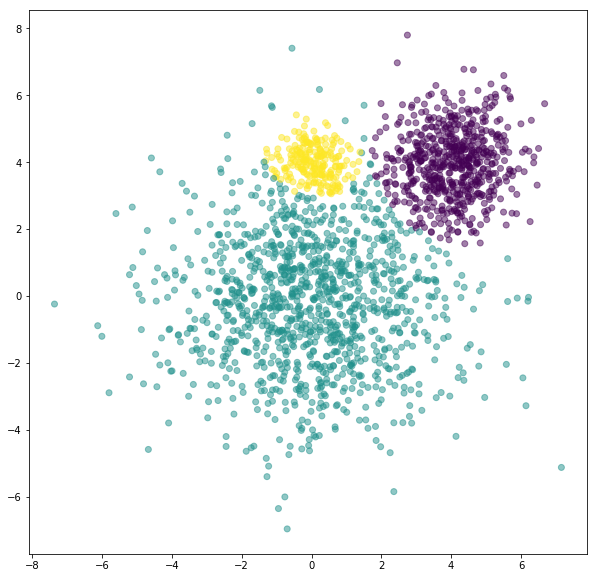

In [21]:
df = pd.read_csv("../data/gmm.csv", names=['x', 'y'], header=None)
gmm = GaussianMixtureModel(df.values)
t0 = datetime.now()
gmm.fit(3)
dt = datetime.now() - t0
y = gmm.r.argmax(axis=0)

fig = plt.figure(figsize=(10,10))
plt.scatter(df.x, df.y, c=y, alpha=.5)

In [25]:
print("Run-Time: {}".format(dt))

Run-Time: 0:00:00.101332
